## IMERG Rainfall `Classes`

* The aim of this notebook is to get the rainfall class percentages from the `train`, `val` and `test` dataset splits.

In [1]:
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
from pathlib import Path
import seaborn as sns
import numpy as np
import dask
from scipy import io
import xarray as xr
from skimage import exposure

from rainnow.src.configs.data_processing_configs import sequencing_config
from rainnow.src.dyffusion.datamodules.imerg_precipitation import IMERGPrecipitationDataModule
from rainnow.src.plotting import plot_sequence
from rainnow.src.configs.config import PATCH_SIZE
from rainnow.src.normalise import PreProcess
from rainnow.src.utilities.loading import load_imerg_datamodule_from_config

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/tensordict/_pytree.py:147: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  register_pytree_node(


In [3]:
# CONFIGS_BASE_PATH = "/Users/ds423/git_uni/irp-ds423/rainnow/src/dyffusion/configs/"
CONFIGS_BASE_PATH = "/teamspace/studios/this_studio/irp-ds423/rainnow/src/dyffusion/configs/"
DATAMODULE_CONFIG_NAME = "imerg_precipitation.yaml"

datamodule = load_imerg_datamodule_from_config(
    cfg_base_path=CONFIGS_BASE_PATH,
    cfg_name=DATAMODULE_CONFIG_NAME,
    overrides={
        "boxes": ["0,0", "1,0", "2,0", "2,1"],
        "window": 1,
        "horizon": 8,
        "prediction_horizon": 8,
        "sequence_dt": 1,
    },
)

In [4]:
X_train = datamodule.get_ds_xarray("train", datamodule.train_slice)
X_val = datamodule.get_ds_xarray("validate", datamodule.val_slice)
X_test = datamodule.get_ds_xarray("test", datamodule.test_slice)
X_predict = datamodule.get_ds_xarray("predict", datamodule.predict_slice)

[2024-08-27 20:31:21][imerg_precipitation.py][INFO] --> training, validation & test using 4 (i, j) boxes: ['0,0', '1,0', '2,0', '2,1'].
[2024-08-27 20:31:21][imerg_precipitation.py][INFO] --> train data split: [None, 202301010000]


[2024-08-27 20:31:22][imerg_precipitation.py][INFO] --> training, validation & test using 4 (i, j) boxes: ['0,0', '1,0', '2,0', '2,1'].
[2024-08-27 20:31:22][imerg_precipitation.py][INFO] --> validate data split: [202301010000, 202307010000]
[2024-08-27 20:31:22][imerg_precipitation.py][INFO] --> training, validation & test using 4 (i, j) boxes: ['0,0', '1,0', '2,0', '2,1'].
[2024-08-27 20:31:22][imerg_precipitation.py][INFO] --> test data split: [202307010000, 202401010000]
[2024-08-27 20:31:22][imerg_precipitation.py][INFO] --> training, validation & test using 4 (i, j) boxes: ['0,0', '1,0', '2,0', '2,1'].
[2024-08-27 20:31:22][imerg_precipitation.py][INFO] --> predict data split: [202303070000, 202303100000]


In [5]:
assert len([i for i in X_predict.time.values if i in X_train.time.values]) == 0
assert len([i for i in X_predict.time.values if i in X_val.time.values]) == 0
assert len([i for i in X_predict.time.values if i in X_test.time.values]) == len(X_predict.time)

In [6]:
# convert it to numpy for easier plotting.
data_train = X_train.to_numpy()
data_val = X_val.to_numpy()
data_test = X_test.to_numpy()
data_predict = X_predict.to_numpy()

data_train.shape, data_val.shape, data_test.shape, data_predict.shape

((13471, 9, 128, 128),
 (2269, 9, 128, 128),
 (984, 9, 128, 128),
 (53, 9, 128, 128))

In [7]:
classes = [0.5, 2, 6, 10, 18, 30]  # rainfall classes mmh-1 .

# Code adapted from:
# - https://www.mdpi.com/2078-2489/11/4/183
# - https://www.sciencedirect.com/science/article/pii/S0098300424000128
# - https://proceedings.neurips.cc/paper/2017/file/a6db4ed04f1621a119799fd3d7545d3d-Paper.pdf

data_binned = np.digitize(data_train, classes, right=True)  # <= N

total_pixels = len(data_binned.flatten())


def print_bin_stats(bin_value, comparison, bin_threshold=None):
    count = np.sum(data_binned == bin_value)
    percentage = (count / total_pixels) * 100
    threshold = f"{bin_threshold}" if bin_threshold is not None else f"{classes[bin_value]}"
    print(f"num pixels {comparison} {threshold}: {count} --> {percentage:.2f}%")


for i in range(6):
    print_bin_stats(i, "<")
print_bin_stats(6, ">", classes[5])

num pixels < 0.5: 1799974161 --> 90.62%
num pixels < 2: 109436779 --> 5.51%
num pixels < 6: 59008104 --> 2.97%
num pixels < 10: 11455167 --> 0.58%
num pixels < 18: 4899858 --> 0.25%
num pixels < 30: 1291229 --> 0.07%
num pixels > 30: 314478 --> 0.02%


In [8]:
classes = [0.5, 2, 6, 10, 18, 30]  # rainfall classes mmh-1 .
split_classes = {}

for d, s in [(data_train, "train"), (data_val, "val"), (data_test, "test")]:
    print(f"processing {s}...")
    d_classes = {}
    total_pixels = len(d.flatten())
    data_binned = np.digitize(d, classes, right=True)  # <= N
    pixel_cnt = 0
    for c in range(len(classes)):
        num_pixels = np.sum(data_binned == c)
        d_classes[f"{classes[c]}"] = num_pixels
        pixel_cnt += num_pixels
    # add final bin before adding to main.
    d_classes[f"-1"] = total_pixels - pixel_cnt
    split_classes[s] = [d_classes, total_pixels]

split_classes

processing train...
processing val...
processing test...


{'train': [{'0.5': 1799974161,
   '2': 109436779,
   '6': 59008104,
   '10': 11455167,
   '18': 4899858,
   '30': 1291229,
   '-1': 314478},
  1986379776],
 'val': [{'0.5': 303631369,
   '2': 18324306,
   '6': 9796027,
   '10': 1815436,
   '18': 770667,
   '30': 189221,
   '-1': 50638},
  334577664],
 'test': [{'0.5': 130875627,
   '2': 8211668,
   '6': 4398793,
   '10': 926025,
   '18': 450120,
   '30': 178935,
   '-1': 55536},
  145096704]}

In [9]:
raw_bins = []
for e, i in enumerate(classes):
    if e == 0:
        raw_bins.append((0.0, i))
    elif e < (len(classes) - 1):
        raw_bins.append((classes[e - 1], i))
    else:
        raw_bins.append((i, np.inf))
flat_raw_bins = sorted(list(set([edge for bin_range in raw_bins for edge in bin_range])))

/tmp/ipykernel_7617/2869173796.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels([f"x ≤ {i}" for i in flat_raw_bins[1:-1]] + [f"x > {flat_raw_bins[-2]}"], rotation=70, fontsize=fs_pct)
/tmp/ipykernel_7617/2869173796.py:61: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(
/tmp/ipykernel_7617/2869173796.py:87: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(


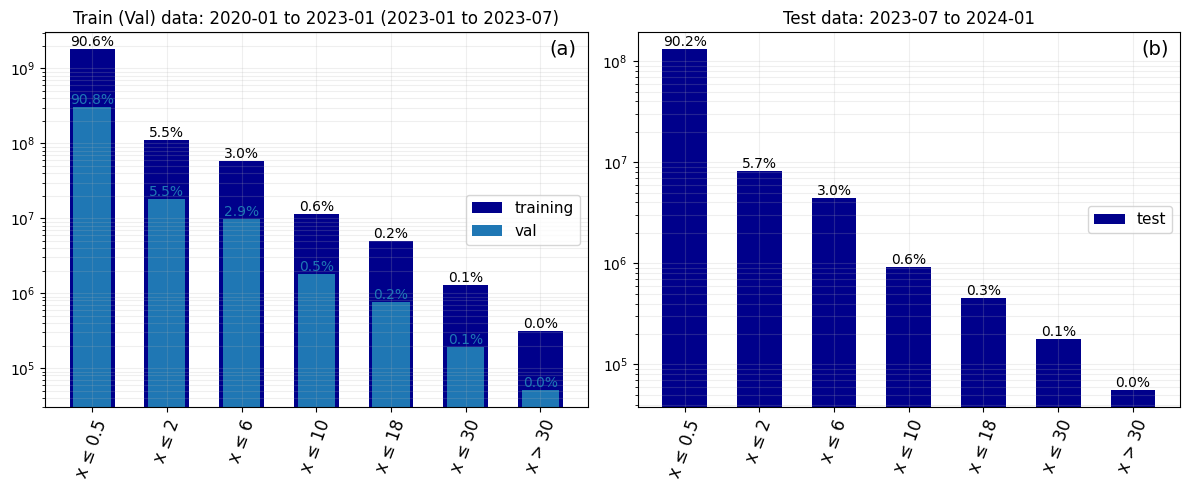

In [29]:
global_params = {
    "font.size": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
}

fs, fs_pct = 12, 10

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
plt.rcParams.update(global_params)

# raw weights dist.
axs[0].bar(
    range(len(flat_raw_bins[:-1])),
    [v for k, v in split_classes["train"][0].items()],
    alpha=1,
    color="darkblue",
    label="training",
    width=0.6,
)
# axs[0].set_xlabel("Precipitation Intensity (mm/h)")
axs[0].set_title("Train (Val) data: 2020-01 to 2023-01 (2023-01 to 2023-07)", fontsize=fs)
axs[0].set_yscale("log")
axs[0].grid(True, which="both", ls="-", alpha=0.2)

# add training data.
for i, (rect, perc) in enumerate(
    zip(
        axs[0].patches,
        [(v / split_classes["train"][1]) * 100 for k, v in split_classes["train"][0].items()],
    )
):
    height = rect.get_height()
    axs[0].text(rect.get_x() + rect.get_width() / 2, height, f"{perc:.1f}%", ha="center", va="bottom")
axs[0].set_xticklabels(
    [f"x ≤ {i}" for i in flat_raw_bins[1:-1]] + [f"x > {flat_raw_bins[-2]}"],
    rotation=70,
    fontsize=fs_pct,
)

# add validation data.
# axs[0].bar(range(len(flat_raw_bins[1:-1])), [v for k, v in split_classes['val'][0].items()], alpha=1, color="C0", label="val", width=.5)
# Plot validation data bars
val_bars = axs[0].bar(
    range(len(flat_raw_bins[:-1])),
    [v for k, v in split_classes["val"][0].items()],
    alpha=1,
    color="C0",
    label="val",
    width=0.5,
)
for i, (rect, perc) in enumerate(
    zip(val_bars, [(v / split_classes["val"][1]) * 100 for k, v in split_classes["val"][0].items()])
):
    height = rect.get_height()
    axs[0].text(
        rect.get_x() + rect.get_width() / 2,
        height,
        f"{perc:.1f}%",
        color="C0",
        ha="center",
        va="bottom",
        fontsize=fs_pct,
    )
axs[0].set_xticklabels(
    [f"x ≤ {i}" for i in flat_raw_bins[:-1]] + [f"x > {flat_raw_bins[-2]}"], rotation=70, fontsize=fs
)
axs[0].legend(loc="best", fontsize=11)

# raw weights dist.
axs[1].bar(
    range(len(flat_raw_bins[:-1])),
    [v for k, v in split_classes["test"][0].items()],
    alpha=1,
    color="darkblue",
    label="test",
    width=0.6,
)
axs[1].set_title("Test data: 2023-07 to 2024-01", fontsize=fs)
axs[1].set_yscale("log")
axs[1].grid(True, which="both", ls="-", alpha=0.2)
axs[1].legend(loc="best", fontsize=11)
for i, (rect, perc) in enumerate(
    zip(
        axs[1].patches,
        [(v / split_classes["test"][1]) * 100 for k, v in split_classes["test"][0].items()],
    )
):
    height = rect.get_height()
    axs[1].text(
        rect.get_x() + rect.get_width() / 2,
        height,
        f"{perc:.1f}%",
        ha="center",
        va="bottom",
        fontsize=fs_pct,
    )
axs[1].set_xticklabels(
    [f"x ≤ {i}" for i in flat_raw_bins[:-1]] + [f"x > {flat_raw_bins[-2]}"], rotation=70, fontsize=fs
)

axs[0].text(
    0.98, 0.98, "(a)", transform=axs[0].transAxes, fontsize=14, va="top", ha="right", color="black"
)
axs[1].text(
    0.98, 0.98, "(b)", transform=axs[1].transAxes, fontsize=14, va="top", ha="right", color="black"
)


plt.tight_layout()
plt.show()

In [11]:
# instantiate the pprocessor object.
pprocessor = PreProcess(
    percentiles=datamodule.normalization_hparams["percentiles"],
    minmax=datamodule.normalization_hparams["min_max"],
)

# preprocess the data.
data_pprocessed = pprocessor.apply_preprocessing(data_train)
normed_classes = pprocessor.apply_preprocessing(np.array(classes))

[2024-08-27 20:33:06][normalise.py][INFO] --> pprocessing w/ percentiles (1st, 99th): [0.0, 5.670000076293945],  (min, max): [0.0, 3.23434630590838]


In [12]:
raw_bins = []
for e, i in enumerate(classes):
    if e == 0:
        raw_bins.append((0.0, i))
    elif e < (len(normed_classes) - 1):
        raw_bins.append((classes[e - 1], i))
    else:
        raw_bins.append((i, np.inf))
flat_raw_bins = sorted(list(set([edge for bin_range in raw_bins for edge in bin_range])))

pp_bins = []
for e, i in enumerate(normed_classes):
    if e == 0:
        pp_bins.append((0.0, i))
    elif e < (len(normed_classes) - 1):
        pp_bins.append((normed_classes[e - 1], i))
    else:
        pp_bins.append((i, 1.0))
flat_pp_bins = sorted(list(set([edge for bin_range in pp_bins for edge in bin_range])))

print(f"** RAW bins = {flat_raw_bins} **")
print(f"** Preprocessed bins = {flat_pp_bins} **")

** RAW bins = [0.0, 0.5, 2, 6, 10, 18, 30, inf] **
** Preprocessed bins = [0.0, 0.026128840604619716, 0.0934122278677847, 0.2231771904950559, 0.3143012015084241, 0.44182631060355715, 0.5686221252667547, 1.0] **


In [13]:
# undersample the data and preprocessed data to be able to plot to have less (speed it up...).
print(f"*** RAW data / preprocessed data shape: {data_train.shape[0]} / {data_pprocessed.shape[0]} ***")
jump = 10  # 10%
data_us = data_train[::jump, :, :, :]
data_pprocessed_us = data_pprocessed[::jump, :, :, :]
print(
    f"*** UNDERSAMPLED data / preprocessed data shape: {data_us.shape[0]} / {data_pprocessed_us.shape[0]} ***"
)

*** RAW data / preprocessed data shape: 13471 / 13471 ***
*** UNDERSAMPLED data / preprocessed data shape: 1348 / 1348 ***


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/matplotlib/axes/_axes.py:7037: RuntimeWarning: invalid value encountered in multiply
  boffset = -0.5 * dr * totwidth * (1 - 1 / nx)


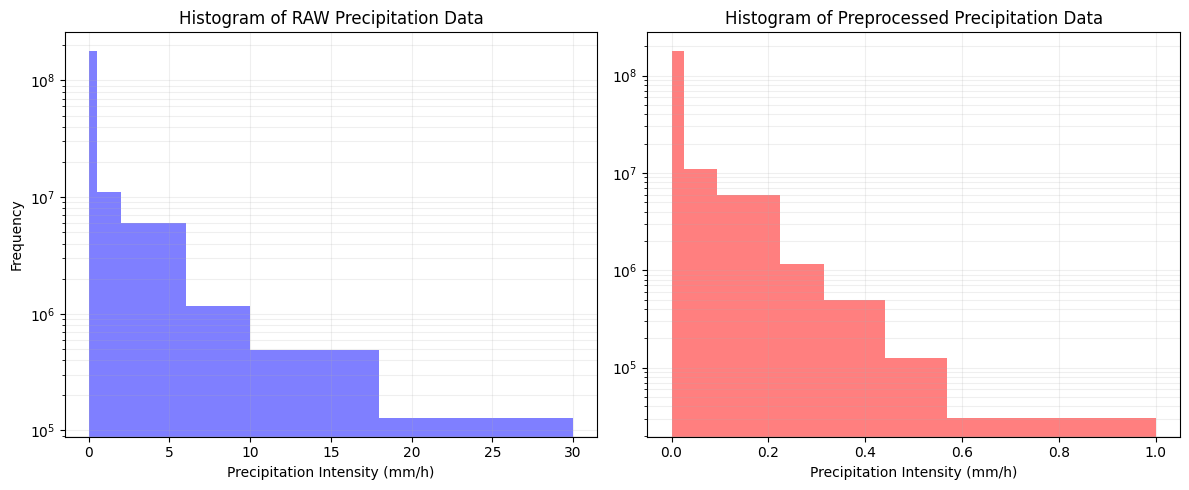

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# raw weights dist.
axs[0].hist(data_us.flatten(), bins=flat_raw_bins, alpha=0.5, color="blue")
axs[0].set_xlabel("Precipitation Intensity (mm/h)")
axs[0].set_ylabel("Frequency")
axs[0].set_title("Histogram of RAW Precipitation Data")
axs[0].set_yscale("log")
axs[0].grid(True, which="both", ls="-", alpha=0.2)

# normed weights dist.
axs[1].hist(data_pprocessed_us.flatten(), bins=flat_pp_bins, alpha=0.5, color="red")
axs[1].set_xlabel("Precipitation Intensity (mm/h)")
axs[1].set_title("Histogram of Preprocessed Precipitation Data")
axs[1].set_yscale("log")
axs[1].grid(True, which="both", ls="-", alpha=0.2)

plt.tight_layout()
plt.show()

### END OF SCRIPT.